In [1]:
from gtda.mapper import Projection
from sklearn.decomposition import PCA

from covertower import CubicalCoverTower, LatticeCoverTower

import surfaces
from multiscale2mapper import Multiscale2Mapper

# Multiscale 2-mapper Tutorial

This notebook briefly goes over generating a multiscale 2-mapper object using the code from this repository. Multiscale 2-mapper construction has well-known dependencies including `gtda.mapper` and `gudhi.SimplexTree`.

We first will generate some data. `surfaces.py` includes sampling from the torus, genus-2 torus, and sphere using the functions `sample_torus`, `sample_g2torus`, and `sample_sphere`, respectively.

In [52]:
data = surfaces.sample_torus(1000)
surfaces.graph_sample(data)

# Multiscale 2-mapper Pipeline

To create a Multiscale 2-mapper from a data set $X$, we choose parameters similar to the mapper algorithm:
- `filter_func` :
        The filter function for the mapper pipeline.
        Default is
        `sklearn.decomposition.PCA(n_componenets=2)`.
- `cover_tower` :
        The tower of covers for the mapper pipeline.
        Choices for cover tower include:
        `covertower.CubicalCoverTower` (each `cover_set` is a `gtda.mapper.cover.CubicalCover` object) and
        `covertower.LatticeCoverTower` (each `cover_set` is a `latticecover.LatticeCover` object).
- `DBSCAN_eps` : float, default `0.5`.
        The epsilon parameters for the clustering algorithm
        `sklearn.cluster.DBSCAN`.
- `DBSCAN_mintpts` : int, default `2`.
        The minimum points for classifying a cluster in 
        `sklearn.cluster.DBSCAN`. 
        Note that if `DBSCAN_minpts` is greater than 2 then 
        *free border points* can occur causing possible 
        miscalculation for the multiscale 2mapper.
        We suggest fixing `DBSCAN_minpts` to 2 or 1.
- `filtration` :
        The filtration value for the multiscale 2mapper.
        Options are ``'overlap_frac'`` and ``'cover_set_volume'``.
- `kwargs` : Additional parameters for the
        `gtda.mapper.pipeline.make_mapper_pipeline` object.
        This should not include `store_edge_elements` as a 
        key, as our pipeline fixes this argument to True.


We use a `gtda.mapper.MapperPipeline` to create a filtration of 2-mappers where we filter over the `cover_sets` in the `cover_tower`. A tower of covers is defined with parameters:
- `tower_size` :
    The number of cover objects in the tower. Each subsequent cover
    contains intervals which are larger in size than the previous cover.
    
- `n_intervals` :
    The number of intervals for each feature dimension
    calculated in :meth:`fit`.

- `start_overlap_frac` :
    The fractional overlap between consecutive intervals in the covers of
    each feature domain calculated in :meth:`fit` for the initial cover.

- `end_overlap_frac` :
    The upper bound on the fractional overlap between consecutive intervals
    in the covers of each feature domain calculated in :meth:`fit` for the 
    final cover in the Tower.

There are additional parameters including `kind`, which specify the cover type further. For instance, `covertower.CubicalCoverTower` can choose `kind='balanced'` or `'uniform'` and `covertower.LatticeCoverTower` can choose `kind='cubical'` or `'triangular'` with the parameter `special` specifying the generating matrix for the lattice (see `covertower.py`).

We fix `sklearn.cluster.DBSCAN` as the clustering algorithm, but you can choose the parameters of `DBSCAN` using `DBSCAN_eps` and `DBSCAN_minpts`. You can choose the filtration value using `filtration`. If you want to choose additional parameters for the `gtda.mapper.MapperPipeline`, you can use an additional dictionary.

To construct the multiscale 2-mapper, we apply `fit_transform` on our data.

In [53]:
mm = Multiscale2Mapper(filter_func=Projection(columns=[0,1]),
                       cover_tower=CubicalCoverTower(tower_size=5,
                                                     start_overlap_frac=0.1,
                                                     end_overlap_frac=0.5,
                                                     n_intervals=10,
                                                     kind='uniform',
                                                     ),
                       DBSCAN_eps=2,
                       filtration='overlap_frac')
mm.fit_transform(data)

Cover Tower: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]

----- Computing Betti Numbers -----


[1, 1]

### Retrieve peristence information from the filtration

We can retrieve the persistence barcodes and persistence diagrams from the filtration using the methods `barcode` and `diagram`, respecitively.

<Axes: title={'center': 'Persistence barcode'}, xlabel='Overlap Fraction g'>

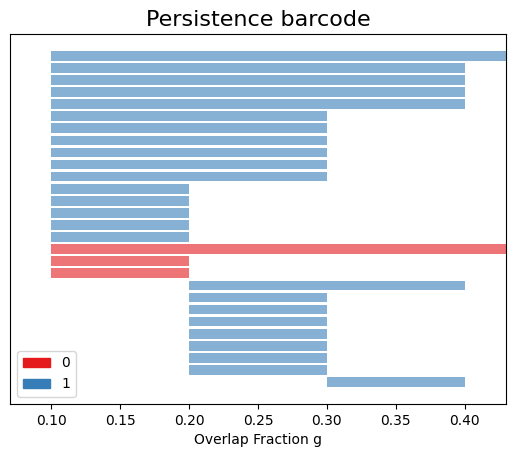

In [57]:
mm.barcode()

<Axes: title={'center': 'Persistence diagram'}, xlabel='Overlap Fraction g', ylabel='Death'>

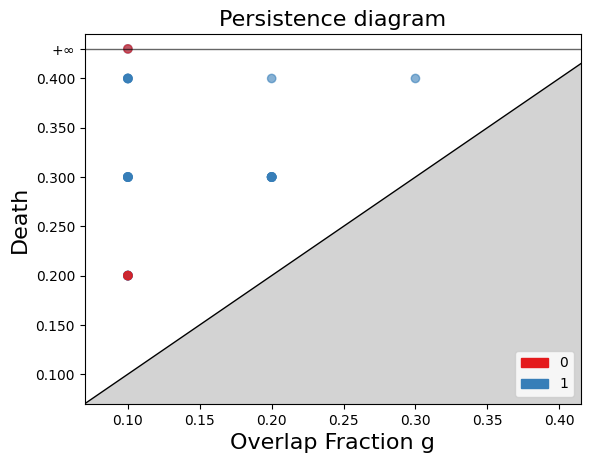

In [58]:
mm.diagram()

### Retrieve mapper information from the filtration

We can additionally view any mapper and 2-mapper from the filtration using `plot_mapper` and `plot_2mapper` methods.
Specify which 2-mapper/mapper to plot with the `filtration_value` parameter. Note that `filtration_value` can either be a value of `Multiscale2Mapper.cover_tower.cover_overlap_fracs` or `Multiscale2Mapper.cover_tower.cover_set_volumes` depending on the choice of `Multiscale2Mapper.filtration`.

We can set different plotting parameters using a dictionary. Each key should be one for `gtda.mapper.visualization.plot_static_mapper_graph`.

In [48]:
# Choose a filtration value
mm.filtration, mm.cover_tower.cover_overlap_fracs

('overlap_frac', array([0.1, 0.2, 0.3, 0.4, 0.5]))

In [55]:
# Extra plotting params
plot_dict = {'layout_dim': 3, 'plotly_params': {'node_trace': {'marker':{'colorscale':'plasma'}}},
             'node_scale': 20}
# Plot the mapper graph
f = mm.plot_mapper(data, filtration_value=0.4, **plot_dict)
f.show()

In [56]:
# Plot the 2-mapper with the same plotting params
g = mm.plot_2mapper(data, filtration_value=0.4, **plot_dict)
g.show()

### View at all mappers in the filtration

Lastly, we also have an additional parameter `plot` in the `fit_transform` method which allows you to view each mapper graph in the filtration while the multiscale 2-mapper is processing. You can also add plotting parameters in the form of a dictionary. This can slow down computation, so it is not advised to be used in every scenario.
For viewing the 2-mapper for each filtration you must use `plot_2mapper` at each spot in the filtration.

In [54]:
mm.fit_transform(data, plot=True, **plot_dict)

Cover Tower:   0%|                                                                          | 0/5 [00:00<?, ?it/s]

Cover Tower:  20%|█████████████▏                                                    | 1/5 [00:00<00:02,  1.94it/s]

Cover Tower:  40%|██████████████████████████▍                                       | 2/5 [00:01<00:01,  1.96it/s]

Cover Tower:  60%|███████████████████████████████████████▌                          | 3/5 [00:01<00:01,  1.96it/s]

Cover Tower:  80%|████████████████████████████████████████████████████▊             | 4/5 [00:02<00:00,  1.71it/s]

Cover Tower: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]

----- Computing Betti Numbers -----


[1, 1]